In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import seaborn as sns

## Load Data

In [2]:
df_data = pd.read_csv('ratings.csv')
df_data.head()

,_id,createdAt,experimentType,id,ratedArtworkId,rating,sourceArtworkId,updatedAt,userId
0,5d6d2ffc96c99f0008942167,2019-09-02 15:06:36.784,encode,1.063539e+24,7066,Agree,7066,2019-09-02 15:06:36.784,106353877872766676678
1,5d6d324d96c99f0008942168,2019-09-02 15:16:29.666,encode,1.063539e+24,30499,Agree,7066,2019-09-02 15:16:29.666,106353877872766676678
2,5d6d326596c99f000894216a,2019-09-02 15:16:53.417,encode,1.063539e+24,14825,Agree,7066,2019-09-02 15:16:53.417,106353877872766676678
3,5d6d558396c99f000894216b,2019-09-02 17:46:43.374,encode,1.071123e+24,7066,Agree,7066,2019-09-02 17:46:43.374,107112297045154154350
4,5d6d559396c99f000894216c,2019-09-02 17:46:59.130,encode,1.071123e+24,30499,Agree,7066,2019-09-02 17:46:59.130,107112297045154154350


**Split data by approach**

In [3]:
encode_config = {
    'name': 'Autoencoder algorithm',
    'type': 'encode',
    'base_path': './encode_data'
}

social_graph_config = {
    'name': 'Autoencoder + Social graph data',
    'type': 'social_graph',
    'base_path': './social_graph_data'
}

experiment_config = social_graph_config

In [4]:
df_data_experiment = df_data[df_data['experimentType'] == experiment_config['type']]
print( experiment_config['name'] +' shape: '+ str(df_data_experiment.shape) )

Autoencoder + Social graph data shape: (759, 9)


## Plot Agree distribution

In [5]:
def group_by_artwork(df_data):

    df_artworks = df_data.groupby(['sourceArtworkId', 'ratedArtworkId','rating']).agg({'id':'count'})
    df_artworks = df_artworks.rename(columns={'id':'count'})
    df_artworks = df_artworks.reset_index()
    return df_artworks

In [6]:
df_data_to_plot = group_by_artwork(df_data_experiment)
df_data_to_plot.head()

,sourceArtworkId,ratedArtworkId,rating,count
0,5629,474,Agree,3
1,5629,474,Disagree,3
2,5629,1558,Agree,4
3,5629,1558,Disagree,3
4,5629,1600,Agree,4


**Get reference artworks id**

In [7]:
reference_artworks = df_data_to_plot['sourceArtworkId'].unique()
reference_artworks

array([ 5629,  7066, 33965, 36457, 43809])

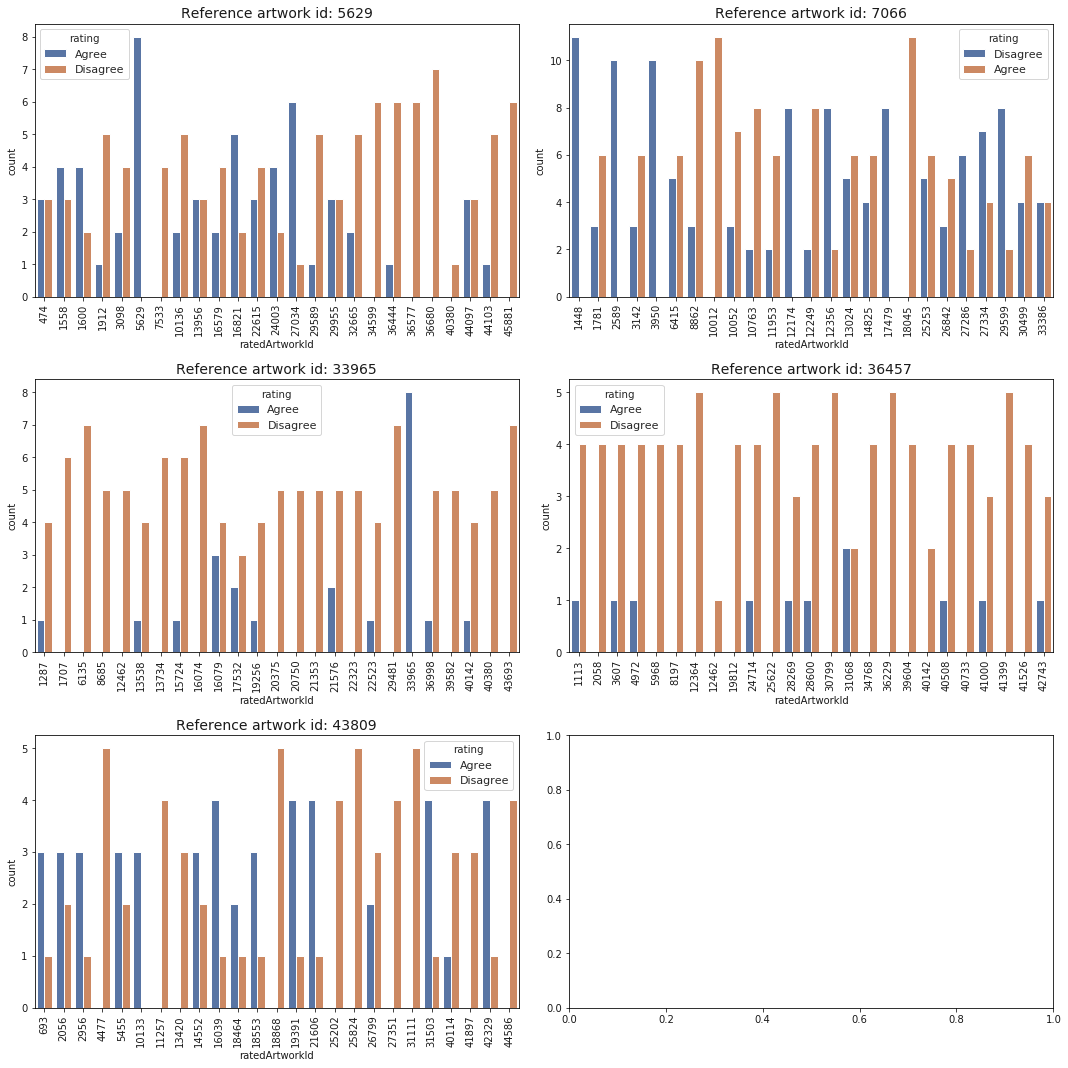

In [8]:
nrows = 3
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15))
sns.set(style="whitegrid")

i = 0
j = 0

for artwork_id in reference_artworks:
    df = df_data_to_plot[df_data_to_plot['sourceArtworkId']==artwork_id]
    ax = sns.barplot(x='ratedArtworkId', y='count', hue='rating', data=df, ax=axs[i,j])

    ax.set_title('Reference artwork id: '+ str(artwork_id), fontdict={'fontsize': 14, 'fontweight': 'medium'})
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    if j < ncols - 1 :
        j += 1
    else:
        i += 1
        j = 0

fig.tight_layout()
plt.show()

**Save plot**

In [ ]:
fig.savefig(experiment_config['type'] +"_agree_dist.png", dpi=100)

**Plot individual artwork**

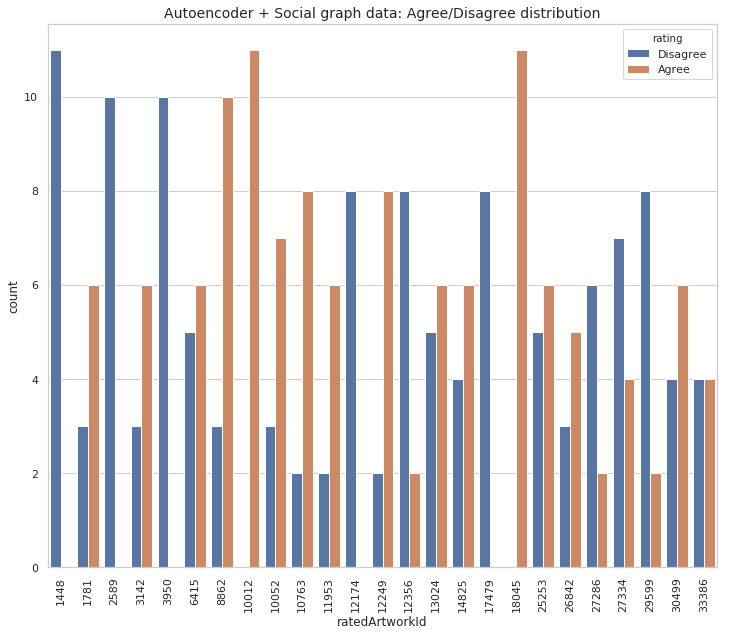

In [9]:
fig = plt.figure(figsize=(12,10))

df = df_data_to_plot[df_data_to_plot['sourceArtworkId']==7066]
ax = sns.barplot(x='ratedArtworkId', y='count', hue='rating', data=df)

ax.set_title(experiment_config['name']+ ': Agree/Disagree distribution', fontdict={'fontsize': 14, 'fontweight': 'medium'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()

In [10]:
fig.savefig(experiment_config['type'] +"_agree_dist_7066.png", dpi=100)

## Precision recall metrics

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, average_precision_score, precision_recall_curve

In [ ]:
df_precision = df_data_to_plot[['sourceArtworkId', 'ratedArtworkId']].drop_duplicates()
df_precision.shape

In [ ]:
df_precision.head()

In [ ]:
def define_hit(row, df):

    agree_rate = 0
    disagree_rate = 0
    
    #Check if there is no vote for agree or disagree 
    if df[(df['sourceArtworkId'] == row['sourceArtworkId']) & (df['ratedArtworkId'] == row['ratedArtworkId']) & (df['rating'] == 'Agree')]['count'].shape[0] != 0:
        agree_rate = df[(df['sourceArtworkId'] == row['sourceArtworkId']) & (df['ratedArtworkId'] == row['ratedArtworkId']) & (df['rating'] == 'Agree')]['count'].values[0]
    if df[(df['sourceArtworkId'] == row['sourceArtworkId']) & (df['ratedArtworkId'] == row['ratedArtworkId']) & (df['rating'] == 'Disagree')]['count'].shape[0] != 0:
        disagree_rate = df[(df['sourceArtworkId'] == row['sourceArtworkId']) & (df['ratedArtworkId'] == row['ratedArtworkId']) & (df['rating'] == 'Disagree')]['count'].values[0]
    
    if agree_rate > disagree_rate:
        return 1
    elif agree_rate < disagree_rate:
        return 0
    else:
        return 1

In [ ]:
df_precision['y_true'] = df_precision.apply(define_hit, axis=1, df=df_data_to_plot)
df_precision['y_pred'] = 1
df_precision.head()

**Select artwork**

In [ ]:
import os
import json

with open(os.path.join(experiment_config['base_path'], 'experimentData.json')) as json_file:
            data_dict = json.loads(json_file.read())

sim_artworks = data_dict['sim_artworks']

artworks_id = []
for s_artwork in sim_artworks:
    artworks_id.append(s_artwork['id'])

artworks_id[:5]

In [ ]:
df_precision_7066 = df_precision[df_precision['sourceArtworkId'] == 7066]
df_precision_7066 = df_precision_7066.set_index('ratedArtworkId')
df_precision_7066.head()

In [ ]:
df_precision_7066 = df_precision_7066.reindex(artworks_id)
df_precision_7066.head()

In [ ]:
#Precision Recall curve
precision_recall_curve(df_precision_7066['y_true'], df_precision_7066['y_pred'])

In [ ]:
k_index = [5,10,15,20, 25]

prec_recall_metrics = []
average_precision_metric = []
for k in k_index:
    #Compute precision and recall
    prec_recall = precision_recall_fscore_support(
        df_precision_7066['y_true'][:k].values, df_precision_7066['y_pred'][:k].values, average='binary')
    prec_recall_metrics.append(prec_recall)
    #Compute average precision
    avr_prec = average_precision_score(
        df_precision_7066['y_true'][:k].values, df_precision_7066['y_pred'][:k].values)
    average_precision_metric.append(avr_prec)

In [ ]:
df_metrics = pd.DataFrame(prec_recall_metrics, 
             index=k_index, columns=['precision', 'recall', 'f_score', 'support'])

df_metrics['avg_precision'] = average_precision_metric

df_metrics

In [ ]:
df_metrics.to_csv(experiment_config['type'] +'_metrics.csv', index=True)

**Precission and Recall for each artwork**

In [ ]:
prec_recall_metrics = []
for artwork_id in reference_artworks:
    df = df_precision[df_precision['sourceArtworkId']==artwork_id]
    prec_recall = precision_recall_fscore_support(df['y_true'], df['y_pred'], average='binary')
    prec_recall_metrics.append(prec_recall)

In [ ]:
pd.DataFrame(prec_recall_metrics, index=reference_artworks, columns=['precision', 'recall', 'f_score', 'support'])